In [2]:
%pip install scikit-learn pyarrow transformers

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

from transformers import BertTokenizerFast, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pyarrow.parquet as pq
import tensorflow as tf
import pandas as pd
import numpy as np
import re

In [ ]:
parrallelism = 8

spark = SparkSession.builder \
                    .appName('BERT BASE App') \
                    .config("spark.dynamicAllocation.enabled", False) \
                    .config("spark.driver.memory", "4g") \
                    .config("spark.cores.max", parrallelism) \
                    .config("spark.executor.instances", parrallelism) \
                    .config("spark.executor.cores", 1) \
                    .config("spark.executor.memory", "4g") \
                    .enableHiveSupport() \
                    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [ ]:
all_items_df = spark.read.table("ruten.items")

In [ ]:
def oversample_data(df, target_col, n=1000, random_state=1234):
    grouped_data = df.groupby(target_col)
    minority_classes = grouped_data.size()[grouped_data.size() < n].index.tolist()
    oversampled_data = [df]

    for class_label in minority_classes:
        class_data = grouped_data.get_group(class_label)
        num_samples_to_add = n - len(class_data) 
        if num_samples_to_add > 0:
            oversampled_class_data = class_data.sample(n=num_samples_to_add, replace=True, random_state=random_state)
            oversampled_data.append(oversampled_class_data)

    return pd.concat(oversampled_data)
    
yugioh_item_df = all_items_df.query("category_name == '遊戲王'").sample(n=40000, random_state=123)

remaining_item_df = all_items_df.query("category_name not in ['其他', '遊戲王'] ")
remaining_item_df = oversample_data(remaining_item_df, 'category_name', 1000)

In [5]:
items_df = pd.concat([yugioh_item_df, remaining_item_df])
items_df

,category_name,item_id,item_name
537412,遊戲王,21842826755145,ca sast jp060 新生融合 亮面
487990,遊戲王,22129927342452,303 051 超魔導劍士 斬龍黑魔導 凸版 浮雕 98 99
530336,遊戲王,22122861086828,d3 sc小舖 遊戲王 sr02 jp016 日蝕飛龍 普鑽 95 98分
433956,遊戲王,22136022744362,dark拍賣 遊戲王 金亮 ca 06 連鎖破壞
445594,遊戲王,22122808019656,源氏卡舖 sd33 jp015 同族感染病毒 普卡
...,...,...,...
210887,魚餌,22022608800628,南台灣釣餌 香之溪誘餌 d234063 南臺灣 餌料
225840,魚餌,21449898471490,黑水 3 5g及頭每包10入55元 另有5g8入裝7g 7入裝 及頭鉤 汲頭鉤 鉛頭 尖銳利...
187937,魚餌,21949998051614,迷你釣具 神餌路亞 入鹽 大肥蟲 入濃厚蝦味 比賽冠軍用餌 黑鱸 雷魚 珍珠石斑 必殺款
237994,魚餌,21404239066984,二手全新imakatsu軟蟲 2 5 elite craw 之2 路亞 軟蟲 軟餌


In [ ]:
X = items_df['item_name'].values
y = items_df['category_name'].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20230605)

In [ ]:
MODEL_NAME = "hfl/chinese-macbert-base"

In [ ]:
class BertDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentences: Array of input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask], labels)`
        (or just `[input_ids, attention_mask]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentences,
        labels,
        batch_size=32,
        shuffle=True,
        include_targets=True,
    ):
        self.sentences = sentences
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        self.tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
        self.indexes = np.arange(len(self.sentences))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentences) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentences = self.sentences[indexes]

        # With BERT tokenizer's batch_encode_plus batch of the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.__call__(
            sentences.tolist(),
            add_special_tokens=True,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="tf"
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks], labels
        else:
            return [input_ids, attention_masks]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [ ]:
input_word_ids = Input(shape=(128,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(128,), dtype=tf.int32, name="input_mask")

bert_model = TFBertModel.from_pretrained(MODEL_NAME)
# Freeze the bert_model.
bert_model.trainable = False

# Get the output of the BERT model
output = bert_model([input_word_ids, input_mask])

output  = Dense(len(set(y)), activation='softmax')(output.pooler_output)

model = Model(inputs=[input_word_ids, input_mask], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Some layers from the model checkpoint at hfl/chinese-macbert-base were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at hfl/chinese-macbert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  102267648   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
batch_size = 64
epochs = 10

train_data = BertDataGenerator(
    X_train, y_train, batch_size=batch_size, shuffle=True
)
valid_data = BertDataGenerator(
    X_test, y_test, batch_size=batch_size, shuffle=False
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

# Train model with validation data and early stopping
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
8589/8589 [==============================] - 708s 81ms/step - loss: 3.3533 - acc: 0.2900 - val_loss: 2.6337 - val_acc: 0.3967
Epoch 2/10
8589/8589 [==============================] - 689s 80ms/step - loss: 2.7851 - acc: 0.3668 - val_loss: 2.3991 - val_acc: 0.4428
Epoch 3/10
8589/8589 [==============================] - 691s 80ms/step - loss: 2.6561 - acc: 0.3894 - val_loss: 2.2873 - val_acc: 0.4647
Epoch 4/10
8589/8589 [==============================] - 689s 80ms/step - loss: 2.5925 - acc: 0.4012 - val_loss: 2.2458 - val_acc: 0.4734
Epoch 5/10
8589/8589 [==============================] - 690s 80ms/step - loss: 2.5433 - acc: 0.4097 - val_loss: 2.2458 - val_acc: 0.4739
Epoch 6/10
8589/8589 [==============================] - 690s 80ms/step - loss: 2.5134 - acc: 0.4159 - val_loss: 2.2336 - val_acc: 0.4791
Epoch 7/10
8589/8589 [==============================] - 689s 80ms/step - loss: 2.4897 - acc: 0.4203 - val_loss: 2.1793 - val_acc: 0.4825
Epoch 8/10
8589/8589 [===================

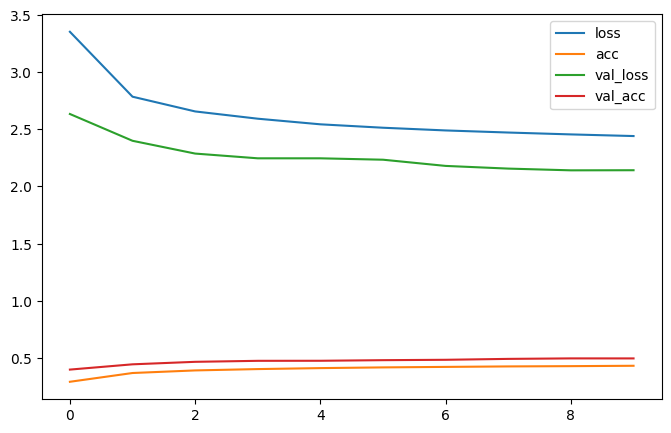

954/954 [==============================] - 64s 67ms/step - loss: 2.1406 - acc: 0.4947


[2.1405844688415527, 0.4947097599506378]

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

model.evaluate(valid_data)

In [ ]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  102267648   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=5,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/5
8589/8589 [==============================] - 1627s 184ms/step - loss: 1.2697 - accuracy: 0.6670 - val_loss: 0.9969 - val_accuracy: 0.7290
Epoch 2/5
8589/8589 [==============================] - 1547s 180ms/step - loss: 0.9488 - accuracy: 0.7386 - val_loss: 0.8804 - val_accuracy: 0.7603
Epoch 3/5
8589/8589 [==============================] - 1546s 180ms/step - loss: 0.8033 - accuracy: 0.7727 - val_loss: 0.8148 - val_accuracy: 0.7781
Epoch 4/5
8589/8589 [==============================] - 1546s 180ms/step - loss: 0.6932 - accuracy: 0.7993 - val_loss: 0.7796 - val_accuracy: 0.7901
Epoch 5/5
8589/8589 [==============================] - 1546s 180ms/step - loss: 0.6046 - accuracy: 0.8221 - val_loss: 0.7734 - val_accuracy: 0.7987


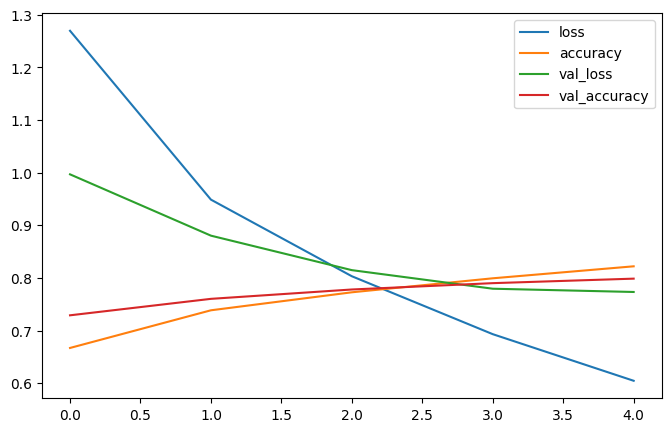

954/954 [==============================] - 65s 68ms/step - loss: 0.7734 - accuracy: 0.7987


[0.7733530402183533, 0.7986930012702942]

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

model.evaluate(valid_data)

In [ ]:
model.save("/tmp/bert_model_base.h5")

In [ ]:
!hdfs dfs -copyFromLocal "/tmp/bert_model.h5" "/ruten/bert_model_base.h5"